In [5]:
from mpl_toolkits.basemap import Basemap  # import Basemap matplotlib toolkit
import numpy as np
import matplotlib.pyplot as plt
import pygrib # import pygrib interface to grib_api
from glob import glob 
import pandas as pd
from matplotlib.dates import  DateFormatter
from reader import read_coordinates, read_variable, read_dates
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
import xarray as xr

In [6]:
# Get coordinates 
lats, lons = read_coordinates()

In [4]:
# Define basemap projection
# m = Basemap(projection='nsper',lon_0=-25, lat_0=25,resolution='c',satellite_height=20000000)
m = Basemap(projection='moll',lon_0=0,resolution='c')
x, y = m(lons,lats)

In [7]:
# main_folder='/scratch/local1/m300382/icon_eps/'
# file_prefix='icon-eps_global_icosahedral'
# level_type='single-level'
# run=''
t2m = read_variable(variable='t_2m')
time= read_dates()
t2m = t2m-273.15

u10m = read_variable(variable='u_10m')
v10m = read_variable(variable='v_10m')
wind_speed=np.sqrt(u10m**2+v10m**2)*3.6

tot_prec = read_variable(variable='tot_prec')

In [8]:
# Compute statistics 
t2_mean=t2m.mean(axis=1)
t2_std=t2m.std(axis=1)

/home/mpim/m300382/.conda/envs/my_env/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'tri'
  s)


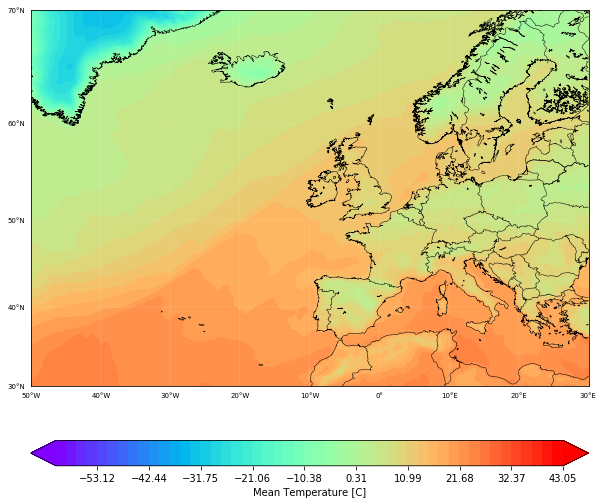

In [11]:
fig = plt.figure(figsize=(10,10))

m = Basemap(projection='mill', llcrnrlon=-50, llcrnrlat=30, urcrnrlon=30, urcrnrlat=70,resolution='i')
x, y = m(lons,lats)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='black')
m.drawcountries(linewidth=0.5, linestyle='solid', color='black')
m.drawparallels(np.arange(-90.0, 90.0, 10.), linewidth=0.2, color='white',
                labels=[True, False, False, True], fontsize=7)
m.drawmeridians(np.arange(0.0, 360.0, 10.), linewidth=0.2, color='white',
                labels=[True, False, False, True], fontsize=7)

levels=np.linspace(t2_mean.min(), t2_mean.max(), 50)
# cs = plt.tricontourf(x, y, t2_mean[1,:], extend='both', cmap='rainbow', levels=levels)
cs = m.contourf(x, y, t2_mean[1,:], extend='both', cmap='rainbow', levels=levels, tri=True)

plt.colorbar(orientation='horizontal', label='Mean Temperature [C]', pad=0.1, fraction=0.05)

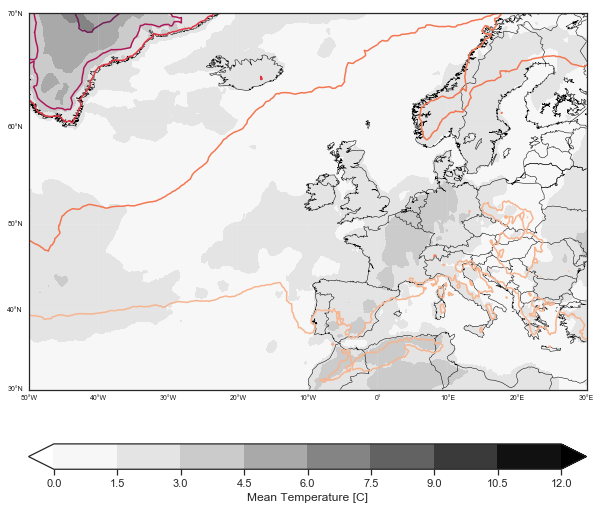

In [146]:
fig = plt.figure(figsize=(10,10))

m = Basemap(projection='mill', llcrnrlon=-50, llcrnrlat=30, urcrnrlon=30, urcrnrlat=70, resolution='l')
x, y = m(lons,lats)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='black')
m.drawcountries(linewidth=0.5, linestyle='solid', color='black')
m.drawparallels(np.arange(-90.0, 90.0, 10.), linewidth=0.2, color='white',
                labels=[True, False, False, True], fontsize=7)
m.drawmeridians(np.arange(0.0, 360.0, 10.), linewidth=0.2, color='white',
                labels=[True, False, False, True], fontsize=7)

# for nens in range(0, t2m.shape[1]):
#     plt.tricontour(x, y, t2m[-1,nens,:], levels=levels)

c = plt.tricontour(x, y, t2_mean[-1,:], extend='both', levels=np.linspace(t2_mean.min(), t2_mean.max(), 10))
cs = plt.tricontourf(x, y, t2_std[-1,:], extend='both', cmap='Greys')

plt.colorbar(orientation='horizontal', label='Mean Temperature [C]', pad=0.1, fraction=0.05)

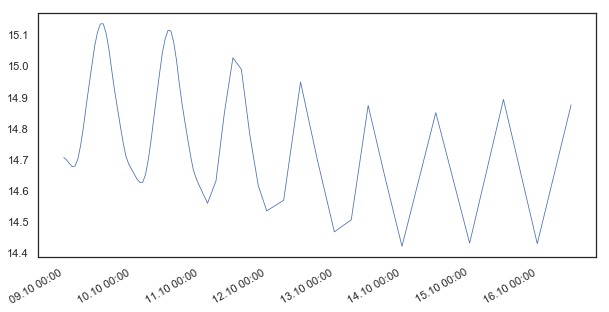

In [38]:
fig = plt.figure(figsize=(10,5))

plt.plot_date(time, t2m.std(axis=(1,2)), '-',linewidth=0.8)
fig.autofmt_xdate()
plt.gca().xaxis.set_major_formatter(DateFormatter('%d.%m %H:%M'))
plt.show()

/home/mpim/m300382/.conda/envs/my_env/lib/python2.7/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


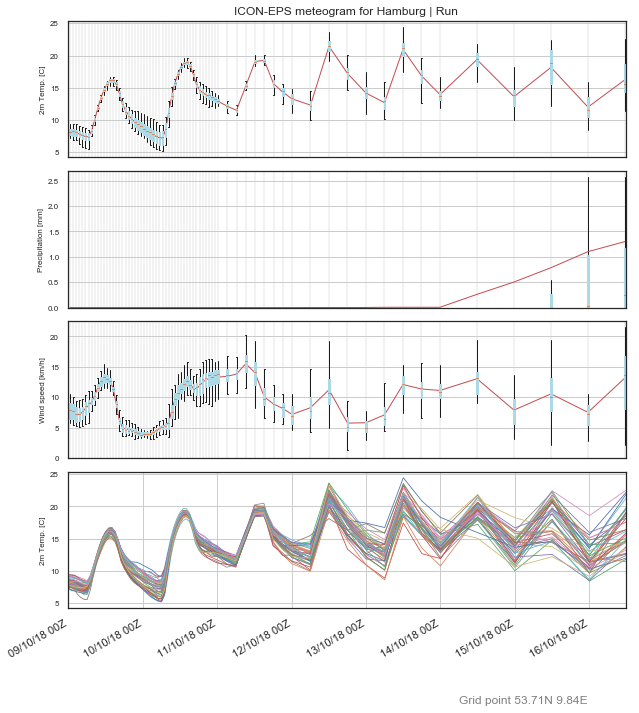

In [135]:
from geopy.geocoders import Nominatim

cities = ["Hamburg"]

nrows=4
ncols=1
sns.set(style="white")
run=''

t_2m_point={}
tot_prec_point={}
wind_speed_10m_point={}

geolocator = Nominatim()
for city in cities:
    loc = geolocator.geocode(city)
    distance = np.sqrt((lats-loc.latitude)**2+(lons-loc.longitude)**2)
    ncell = np.argmin(distance)
    t_2m_point[city] = t2m[:,:,ncell]
    tot_prec_point[city] = tot_prec[:,:,ncell]
    wind_speed_10m_point[city] = wind_speed[:,:,ncell]
    
    fig = plt.figure(1, figsize=(10,12))
    
    pos = np.array((time-time[0]) / pd.Timedelta('1 hour')).astype("int")

    ax1=plt.subplot2grid((nrows,ncols), (0,0))
    ax1.set_title("ICON-EPS meteogram for "+city+" | Run "+run)
    
    bplot=ax1.boxplot(t_2m_point[city].T, patch_artist=True, showfliers=False, positions=pos)
    for box in bplot['boxes']:
        box.set(color='LightBlue')
        box.set(facecolor='LightBlue')

    ax1.plot(pos, np.mean(t_2m_point[city], axis=1), 'r-', linewidth=1)
    ax1.set_ylabel("2m Temp. [C]",fontsize=8)
    ax1.yaxis.grid(True)
    ax1.xaxis.grid(True, color='gray', linewidth=0.2)
    ax1.tick_params(axis='y', which='major', labelsize=8)
    ax1.tick_params(axis='x', which='both', bottom=False)

    ax2=plt.subplot2grid((nrows,ncols), (1,0))
    bplot_rain=ax2.boxplot(tot_prec_point[city].T, patch_artist=True, showfliers=False, positions=pos)
    for box in bplot_rain['boxes']:
        box.set(color='LightBlue')
        box.set(facecolor='LightBlue')
    ax2.plot(pos, np.mean(tot_prec_point[city], axis=1), 'r-', linewidth=1)
    ax2.set_ylim(bottom=0)
    ax2.yaxis.grid(True)
    ax2.set_ylabel("Precipitation [mm]",fontsize=8)
    ax2.tick_params(axis='y', which='major', labelsize=8)
    ax2.xaxis.grid(True, color='gray', linewidth=0.2)

    ax3=plt.subplot2grid((nrows,ncols), (2,0))
    bplot_wind=ax3.boxplot(wind_speed_10m_point[city].T, patch_artist=True, showfliers=False, positions=pos)
    for box in bplot_wind['boxes']:
        box.set(color='LightBlue')
        box.set(facecolor='LightBlue')
    ax3.plot(pos, np.mean(wind_speed_10m_point[city], axis=1),'r-', linewidth=1)
    ax3.yaxis.grid(True)
    ax3.set_ylabel("Wind speed [km/h]",fontsize=8)
    ax3.tick_params(axis='y', which='major', labelsize=8)
    ax3.set_ylim(bottom=0)
    ax3.xaxis.grid(True, color='gray', linewidth=0.2)
    
    ax4=plt.subplot2grid((nrows,ncols), (3,0))
    ax4.plot_date(time, t_2m_point[city], '-',linewidth=0.8)
    ax4.set_xlim(time[0],time[-1])
    ax4.set_ylabel("2m Temp. [C]",fontsize=8)
    ax4.tick_params(axis='y', which='major', labelsize=8)
    ax4.yaxis.grid(True)
    ax4.xaxis.grid(True)
    ax4.xaxis.set_major_locator(mdates.DayLocator())
    ax4.xaxis.set_major_formatter(DateFormatter('%d/%m/%y %HZ'))
    
    ax4.annotate('Grid point %4.2fN %4.2fE' % (lats[ncell], lons[ncell]), 
                 xy=(0.7, -0.7), xycoords='axes fraction', color="gray")
    
    fig.subplots_adjust(hspace=0.1)
    fig.autofmt_xdate()
    plt.show()
#     plt.savefig(diri_images+"meteogram_"+city, dpi=150, bbox_inches='tight')
#     plt.clf()